In [8]:
import pandas as pd

# pygad es una librería de algoritmos genéticos (https://pygad.readthedocs.io/en/latest/pygad.html)
!pip install pygad
import pygad

In [9]:
# carga de datos YA BINARIOS.
# Requiere fichero lungcancer_binario.csv en GitHub

df = pd.read_csv('lungcancer_binario.csv')

df

,Fumador,DedosAmarillos,Ansiedad,Hipertension,EnfermedadCronica,Fatiga,Alergia,Silbidos,ConsumidorAlcohol,Tos,DificultadRespirar,DificultadTragar,DolorPecho,Sexo_F,Sexo_M,RangoEdad_20-59,RangoEdad_59-67,RangoEdad_67-87,CancerPulmon
0,0,1,1,0,0,1,0,1,1,1,1,1,1,0,1,0,0,1,1
1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1
2,0,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,0
3,1,1,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0
4,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,0,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1
280,1,0,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0
281,1,0,0,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,0
282,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0


In [10]:
# cambiar formato datos (de dataframe al formato mostrado: lista de variables predictoras y valor real)

datos = []

for elem in df.values.tolist():
  datos.append((elem[0:-1], int(elem[-1])))  # la variable a predecir debe estar en la última columna

datos[0:3]  # tres primeras filas

[([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1], 1),
 ([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1], 1),
 ([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0], 0)]

In [14]:
# separar en train y test (80%/20%)
from sklearn.model_selection import train_test_split

# Separa en train y test (80% train, 20% test)
Xtrain, Xtest = train_test_split(datos, test_size=0.2, random_state=42)

print(len(Xtrain), len(Xtest))

227 57


In [15]:
import numpy as np

# ESTA FUNCIÓN ES 6 VECES MÁS RÁPIDA QUE LAS FUNCIONES f1_score y accuracy_score de sklearn

def evaluar_metrica(individuo, datos, metrica='F1'):
    umbral = 0.5
    # extraer atributos y Yreal en matrices de NumPy
    X = np.array([elem[0] for elem in datos])  # Matriz de atributos
    Yreal = np.array([elem[1] for elem in datos])  # Vector de etiquetas reales

    # calcular el producto de pesos usando la multiplicación matricial
    producto_pesos = np.dot(X, individuo)

    # aplicar el umbral para las predicciones
    Ypred = (producto_pesos >= umbral).astype(int)  # Predicción binaria (1 o 0)

    # calcular TP, TN, FP y FN
    TP = np.sum((Ypred == 1) & (Yreal == 1))
    TN = np.sum((Ypred == 0) & (Yreal == 0))
    FP = np.sum((Ypred == 1) & (Yreal == 0))
    FN = np.sum((Ypred == 0) & (Yreal == 1))

    # Calcular la métrica
    if metrica in ['accuracy', 'acc', 'acc_score', 'Accuracy', 'Acc', 'Acc_score']:
        score = (TP + TN) / (TP + TN + FP + FN)
    elif metrica in ['f1', 'F1', 'f_1', 'F_1', 'F1_score', 'f1_score']:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

    return score

In [13]:
# DE PRUEBA
individuo_inicial = [(1/len(individuo))] * len(individuo)  # individuo normalizado con los 18 pesos iguales

evaluar_metrica(individuo_inicial, Xtrain, metrica='F1')

NameError: name 'individuo' is not defined

In [16]:
# para calcular el fitness (mejor usar SIEMPRE f1, que es más fiable)
def fitness_function(ga_instance, solution, solution_idx):
  individuo = solution
  score = evaluar_metrica(individuo, Xtrain, metrica='F1')   # F1, accuracy
  return score

# normalización de todos los individuos después de obtenerlos mediante cruce y mutación
def on_crossover(ga_instance, offspring_crossover):
  # Calculamos la suma de los genes de cada individuo
  total = np.sum(offspring_crossover, axis=1).reshape(-1, 1)
  # Evitamos divisiones por cero reemplazando con 1 en los casos donde la suma sea 0
  total[total == 0] = 1
  # Normalizamos dividiendo todos los genes por la suma correspondiente
  offspring_crossover = offspring_crossover / total
  return offspring_crossover

# función auxiliar de generate_population para generar un solo individuo normalizado
def generate_individual(individuo_size):
    # Genera 4 números aleatorios y los normaliza para que sumen 1
    individual = np.random.rand(individuo_size)
    individual /= individual.sum()  # Normalizar para que sumen 1
    return individual

# generar población del tamaño correspondiente y con individuos del tamaño correspondiente
def generate_population(population_size, individuo_size):
    return [generate_individual(individuo_size) for _ in range(population_size)]

# para ir mostrando el progreso (el mejor de cada generación)
def callback_generation(ga_instance):
  cada_x = 100
  # Mostrar solo una de cada x generaciones
  if ga_instance.generations_completed % cada_x == 0:
    print(f"Generación {ga_instance.generations_completed} - Fitness de la mejor solución: {ga_instance.best_solution()[1]}")

In [24]:
#Función tipo GridSearch para encontrar los mejores parámetros, esta función itera entre los posibles parámetros que le pasamos y devuelve la combinación que mejores resultados en test da

def best_parameters(num_generations_range, num_parents_mating_range, mutation_percent_genes_range, population_size_range, genes_num, Xtest):
    # Variables para almacenar el mejor resultado
    best_params = None
    best_fitness = -np.inf

    # Bucle para probar todas las combinaciones de hiperparámetros
    for num_generations in num_generations_range:
        for num_parents_mating in num_parents_mating_range:
            for mutation_percent_genes in mutation_percent_genes_range:
                for population_size in population_size_range:
                
                    print(f"Probando: num_generations={num_generations}, num_parents_mating={num_parents_mating}, mutation_percent_genes={mutation_percent_genes}, population_size={population_size}")
                    
                    # Crear una nueva instancia del algoritmo genético con los parámetros actuales
                    ga_instance = pygad.GA(
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_function,
                        sol_per_pop=population_size,
                        num_genes=genes_num,
                        initial_population=generate_population(population_size, genes_num),
                        mutation_percent_genes=mutation_percent_genes,
                        gene_type=float,
                        on_crossover=on_crossover,
                        on_generation=callback_generation
                    )
                    
                    # Ejecutar el algoritmo genético
                    ga_instance.run()
                    
                    # Obtener la mejor solución y su fitness
                    best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
                    print(f"Best solution (train fitness): {best_solution_fitness}")
                    test_fitness = evaluar_metrica(best_solution, Xtest, 'F1')
                    print(f"Fitness value of the best solution (test): {test_fitness}")

                    # Si el fitness de esta combinación es mejor, guardarlo
                    if test_fitness > best_fitness:
                        best_fitness = test_fitness
                        best_params = {
                            'num_generations': num_generations,
                            'num_parents_mating': num_parents_mating,
                            'mutation_percent_genes': mutation_percent_genes,
                            'population_size': population_size
                        }

    # Mostrar los mejores hiperparámetros y su fitness
    print(f"Mejores hiperparámetros: {best_params}")
    print(f"Mejor fitness (TEST): {best_fitness}")
    return best_params, best_fitness
    

c:\Users\alvar\anaconda3\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generación 100 - Fitness de la mejor solución: 0.9509803921568627
Generación 200 - Fitness de la mejor solución: 0.9530864197530866
Generación 300 - Fitness de la mejor solución: 0.9530864197530866
Generación 400 - Fitness de la mejor solución: 0.9530864197530866


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


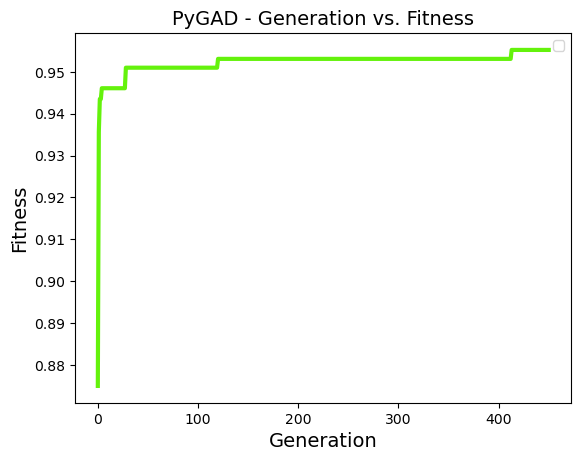

Best solution :  [ 0.43934273  0.33222275  0.90689282 -0.10928186  0.11023431  0.52938387
  0.05278385  0.31195625  0.68727936  0.84169981 -0.01982752  1.78123883
  0.7379268  -0.85355279 -0.73285253  0.428676   -0.40157278 -0.78715505]

Fitness value of the best solution (TRAIN): 0.9552238805970149
Fitness value of the best solution  (TEST): 0.9


In [17]:
# definición y ejecución del algoritmo

# parámetros ajustables (lo que tenemos que optimizar, vaya)
num_generations = 450         # número de generaciones: los resultados sólo pueden igualarse o mejorarse con más generaciones
num_parents_mating = 200      # número de soluciones seleccionadas como "padres". Cuantos más, más exploración
population_size = 300         # número de individuos en cada población. Cuantos más, más exploración
mutation_percent_genes = 60   # porcentaje de genes que se mutan. Cuantos más, más exploración
genes_num = len(datos[0][0])  # simplemente la longitud de los individuos, en este caso 18

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=population_size,
                       num_genes=genes_num,
                       #gene_space=gene_space,  # por ahora no lo usamos
                       initial_population=generate_population(population_size, genes_num),  # genera la población inicial
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=float,  # en nuestro caso, los genes son siempre float, pues son pesos entre 0 y 1
                       on_crossover=on_crossover,
                       on_generation=callback_generation
                       )


ga_instance.run()
ga_instance.plot_fitness()

best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
print("Best solution : ", best_solution)
print("\nFitness value of the best solution (TRAIN):", best_solution_fitness)
print("Fitness value of the best solution  (TEST):", evaluar_metrica(best_solution, Xtest, 'F1'))

In [26]:
# Rangos de hiperparámetros para probar
num_generations_range = [600]
num_parents_mating_range = [300, 250]
mutation_percent_genes_range = [40, 60]
population_size_range = [300, 600]  
# Parámetros fijos
genes_num = len(datos[0][0])  # Número de genes 

#Llamada a la función de búsqueda de los mejores parámetros
mejores_parametros, mejor_fitness = best_parameters(num_generations_range, 
                                                                   num_parents_mating_range, 
                                                                   mutation_percent_genes_range, 
                                                                   population_size, 
                                                                   genes_num, 
                                                                   Xtest)

Probando: num_generations=600, num_parents_mating=300, mutation_percent_genes=40, population_size=300
Generación 100 - Fitness de la mejor solución: 0.9484029484029485
Generación 200 - Fitness de la mejor solución: 0.9526184538653367
Generación 300 - Fitness de la mejor solución: 0.9526184538653367
Generación 400 - Fitness de la mejor solución: 0.9526184538653367
Generación 500 - Fitness de la mejor solución: 0.9526184538653367
Generación 600 - Fitness de la mejor solución: 0.9526184538653367
Best solution (train fitness): 0.9526184538653367
Fitness value of the best solution (test): 0.9215686274509803
Probando: num_generations=600, num_parents_mating=300, mutation_percent_genes=60, population_size=300
Generación 100 - Fitness de la mejor solución: 0.9509803921568627
Generación 200 - Fitness de la mejor solución: 0.9509803921568627
Generación 300 - Fitness de la mejor solución: 0.9509803921568627
Generación 400 - Fitness de la mejor solución: 0.9509803921568627
Generación 500 - Fitness

In [107]:
# GUARDAR RESULTADOS (ejecutar sólo si el resultado es decente o especialmente relevante)
# así llevamos un registro de mejores soluciones
# !! Requiere fichero mejores_resultados.xlsx en GitHub !!

import pandas as pd
import os

# Datos de la mejor solución
best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
train_f1 = evaluar_metrica(best_solution, Xtrain, 'F1')
test_f1 = evaluar_metrica(best_solution, Xtest, 'F1')
train_acc = evaluar_metrica(best_solution, Xtrain, 'accuracy')
test_acc = evaluar_metrica(best_solution, Xtest, 'accuracy')

# Detalles a agregar
data_to_append = {
    'Num Generations': num_generations,
    'Population Size': population_size,
    'Num Parents Mating': num_parents_mating,
    'Mutation Percent Genes': mutation_percent_genes,
    'Best Solution': best_solution,
    'F1 Train': train_f1,
    'F1 Test': test_f1,
    'Accuracy Train': train_acc,
    'Accuracy Test': test_acc,
}

# Nombre del archivo
file_name = 'mejores_resultados.xlsx'

# Comprobar si el archivo existe
if not os.path.isfile(file_name):
    # Si no existe, crear un DataFrame y guardar el archivo
    df = pd.DataFrame(columns=data_to_append.keys())
    df.to_excel(file_name, index=False)

# Leer el archivo existente
df = pd.read_excel(file_name)

# Convertir el diccionario a un DataFrame
new_row = pd.DataFrame([data_to_append])

# Comprobar si la nueva fila ya existe en el DataFrame
# Convertir ambas filas a cadenas para la comparación
new_row_str = new_row.astype(str).iloc[0]
df_str = df.astype(str)

# Verificar si hay una coincidencia
if not ((df_str == new_row_str).all(axis=1).any()):
    # Usar pd.concat para agregar la nueva fila
    df = pd.concat([df, new_row], ignore_index=True)
    # Guardar de nuevo el archivo
    df.to_excel(file_name, index=False)
    print("Resultados guardados en", file_name, "\n\nArchivo completo:")
else:
    print("La solución ya existe en el archivo. No se ha añadido.\n\nArchivo completo:")

# Mostrar el DataFrame
df

Resultados guardados en mejores_resultados.xlsx


,Num Generations,Population Size,Num Parents Mating,Mutation Percent Genes,Best Solution,F1 Train,F1 Test,Accuracy Train,Accuracy Test
0,10000,300,150,30,[ 0.07362127 0.47691532 0.03269929 -0.003638...,0.960199,0.932039,0.929515,0.877193
1,400,300,150,80,"[0.4497091669285508, -0.5212201268166909, 1.28...",0.955665,0.920000,0.920705,0.859649
